## Observational social learning task with a reinforcement-learning-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
from RL import *

In [2]:
sid=1
z=0
k=1
learning_rate = 5e-5
trial = 1
env = Environment(sid=sid, trial=trial)
net, sim = simulate_RL(env=env, seed_net=sid, z=z, k=k, learning_rate=learning_rate, progress_bar=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

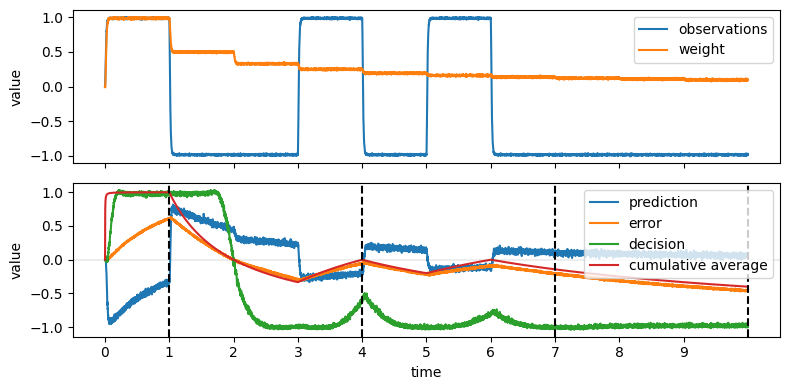

In [4]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
prediction = sim.data[net.probe_prediction].flatten()
decision = sim.data[net.probe_decision].flatten()
def cumulative_average(a):
    return np.cumsum(a) / np.arange(1, len(a) + 1)
cumavg = cumulative_average(input_obs)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=weight, ax=axes[0], label='weight')
sns.lineplot(x=times, y=error, ax=axes[1], label='prediction')
sns.lineplot(x=times, y=prediction, ax=axes[1], label='error')
sns.lineplot(x=times, y=decision, ax=axes[1], label='decision')
sns.lineplot(x=times, y=cumavg, label='cumulative average')

axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+2*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+3*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()